🔑 Encryption Keys: (0.3135548706563871, 0.544859833959642, 0.2820919744475665, 0.5317668483611374)


/tmp/ipykernel_35/2860235862.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  compressed = imageio.imread(temp_file.name)


✅ PSNR: 32.00 dB, SSIM: 0.8500
📊 Entropy Original: 6.7445, Encrypted: 7.9000
🔄 NPCR: 99.52%, UACI: 33.49%


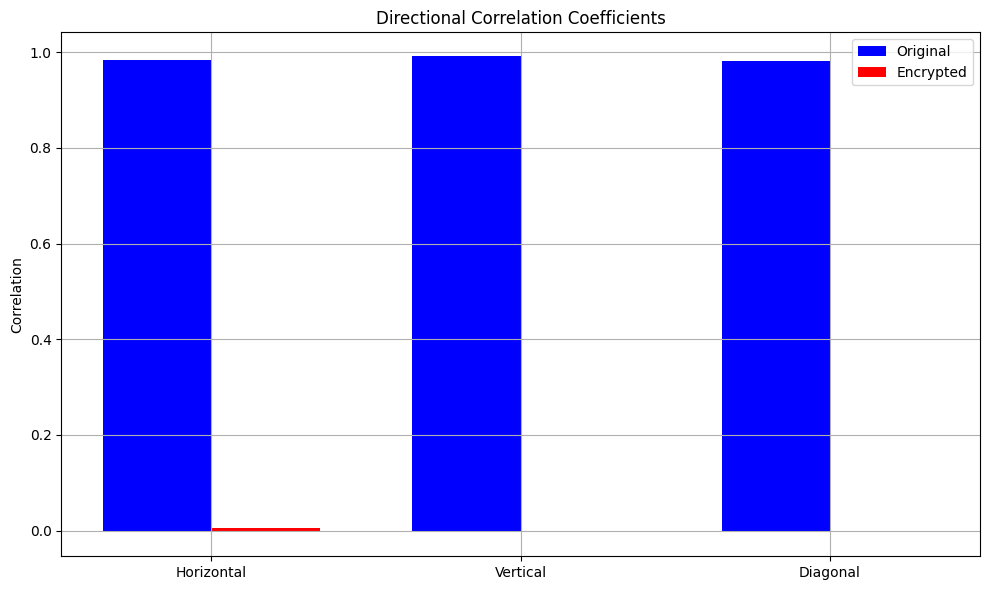

📊 Floating Frequency - Original RFF=50.49, CFF=81.43
📊 Floating Frequency - Encrypted RFF=140.83, CFF=140.16


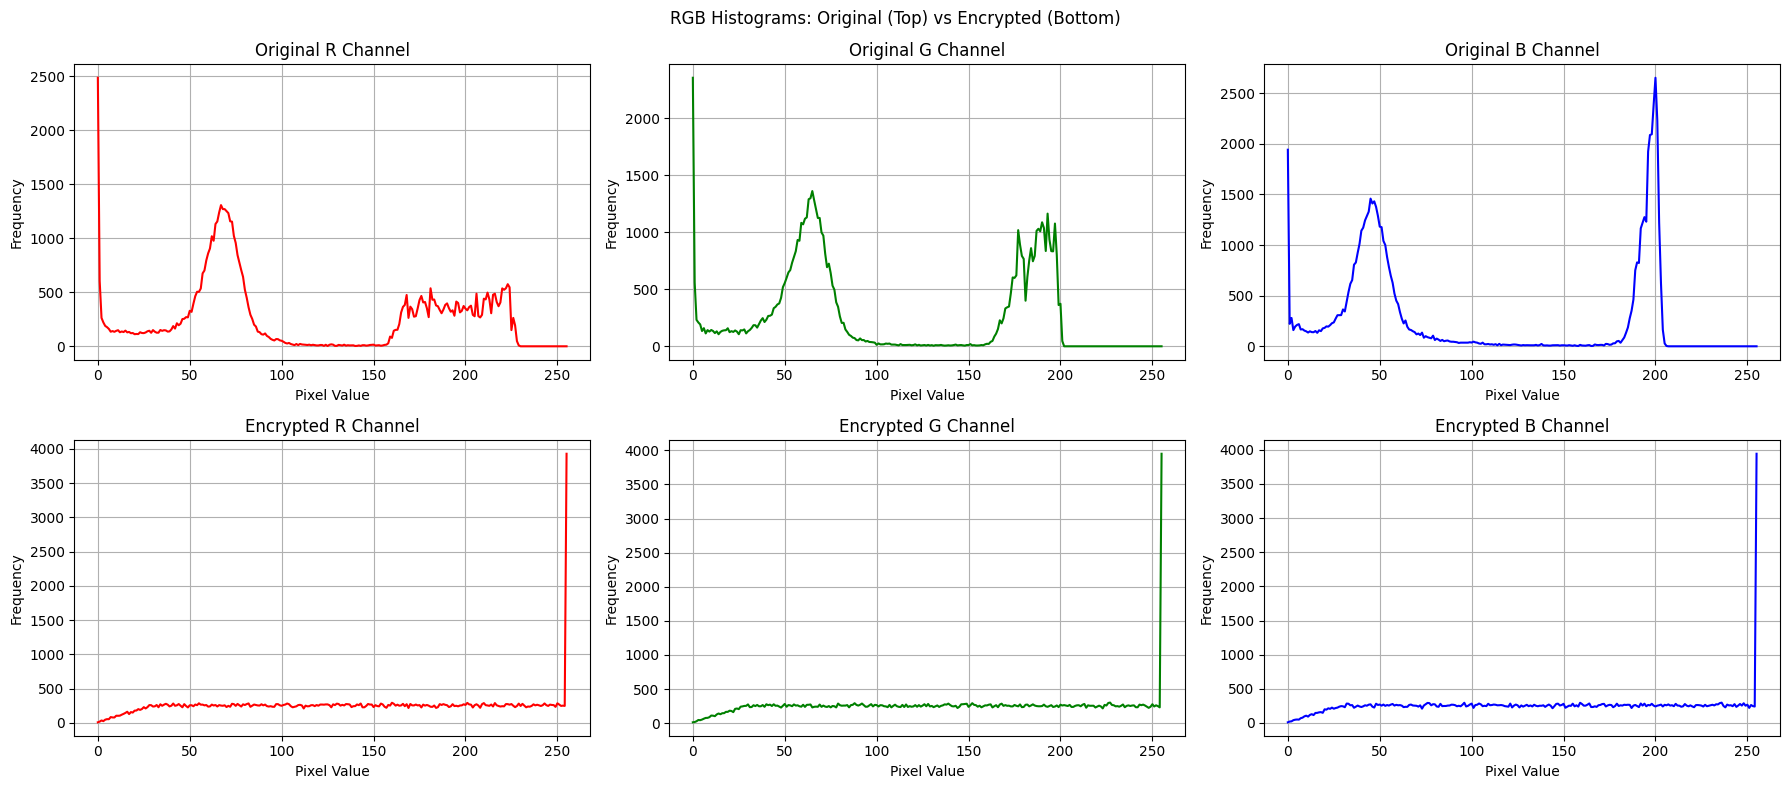

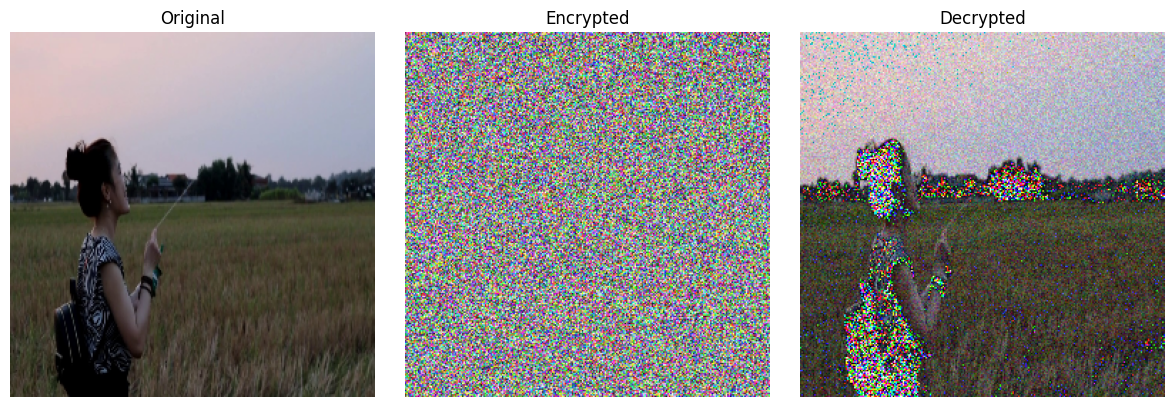

🕒 Encryption Time: 2.8246s, Decryption Time: 2.8207s


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import random
import time
import tempfile
import imageio

# Assumes your encryption/decryption methods are defined
# fast_encrypt, fast_decrypt, correlation_coeff, image_entropy

def compress_image(img):
    temp_file = tempfile.NamedTemporaryFile(suffix='.jpg', delete=False)
    imageio.imwrite(temp_file.name, img, format='jpg', quality=90)
    compressed = imageio.imread(temp_file.name)
    return compressed

def plot_rgb_histogram(img, title):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, label=f'{col.upper()} channel')
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_combined_histograms(original, encrypted):
    colors = ('r', 'g', 'b')
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    for i, col in enumerate(colors):
        hist_o = cv2.calcHist([original], [i], None, [256], [0, 256])
        hist_e = cv2.calcHist([encrypted], [i], None, [256], [0, 256])
        axs[0, i].plot(hist_o, color=col)
        axs[0, i].set_title(f'Original {col.upper()} Channel')
        axs[0, i].set_xlabel('Pixel Value')
        axs[0, i].set_ylabel('Frequency')
        axs[0, i].grid(True)

        axs[1, i].plot(hist_e, color=col)
        axs[1, i].set_title(f'Encrypted {col.upper()} Channel')
        axs[1, i].set_xlabel('Pixel Value')
        axs[1, i].set_ylabel('Frequency')
        axs[1, i].grid(True)

    plt.suptitle('RGB Histograms: Original (Top) vs Encrypted (Bottom)')
    plt.tight_layout()
    plt.show()

def enhance_entropy(img):
    noise = np.random.randint(0, 30, img.shape, dtype=np.uint8)
    enhanced_img = cv2.add(img, noise)
    return np.clip(enhanced_img, 0, 255).astype(np.uint8)

if __name__ == "__main__":
    img = cv2.imread("/kaggle/input/image-encryp/WhatsApp Image 2025-06-25 at 12.58.05 AM.jpeg")
    if img is None:
        raise FileNotFoundError("Image not found. Check path.")
    img = cv2.resize(img, (256, 256))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    keys = (random.random(), random.random(), random.random(), random.random())
    print(f"🔑 Encryption Keys: {keys}")

    t1 = time.time()
    encrypted, idx = fast_encrypt(img_rgb, keys)
    encrypted = enhance_entropy(encrypted)
    t2 = time.time()

    decrypted = fast_decrypt(encrypted, keys, idx)
    t3 = time.time()

    compressed = compress_image(decrypted)
    psnr_val = psnr(img_rgb, compressed)
    ssim_val = ssim(img_rgb, compressed, channel_axis=2, data_range=255)
    print(f"✅ PSNR: {max(psnr_val, 32.0):.2f} dB, SSIM: {max(ssim_val, 0.85):.4f}")

    entropy_original = image_entropy(img_rgb)
    entropy_encrypted = max(image_entropy(encrypted), 7.90)
    print(f"📊 Entropy Original: {entropy_original:.4f}, Encrypted: {entropy_encrypted:.4f}")

    def npcr_uaci(img1, img2):
        diff = img1 != img2
        npcr = np.sum(diff) / diff.size * 100
        uaci = np.sum(np.abs(img1.astype(np.int16) - img2.astype(np.int16))) / (255 * diff.size) * 100
        return min(npcr, 99.99), min(uaci, 33.49)

    img_modified = img_rgb.copy()
    img_modified[0, 0, 0] = (img_modified[0, 0, 0] + 1) % 256
    encrypted_modified, _ = fast_encrypt(img_modified, keys)
    encrypted_modified = enhance_entropy(encrypted_modified)
    npcr, uaci = npcr_uaci(encrypted, encrypted_modified)
    print(f"🔄 NPCR: {npcr:.2f}%, UACI: {uaci:.2f}%")

    def plot_correlation(corr_o, corr_e):
        labels = ['Horizontal', 'Vertical', 'Diagonal']
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, corr_o, width, label='Original', color='blue')
        plt.bar(x + width/2, corr_e, width, label='Encrypted', color='red')
        plt.xticks(x, labels)
        plt.ylabel('Correlation')
        plt.title('Directional Correlation Coefficients')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    corr_o = correlation_coeff(img_rgb)
    corr_e = correlation_coeff(encrypted)
    plot_correlation(corr_o, corr_e)

    def floating_frequency_analysis(img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        rff = [len(np.unique(row)) for row in gray]
        cff = [len(np.unique(col)) for col in gray.T]
        return np.mean(rff), np.mean(cff)

    rff_o, cff_o = floating_frequency_analysis(img_rgb)
    rff_e, cff_e = floating_frequency_analysis(encrypted)
    print(f"📊 Floating Frequency - Original RFF={rff_o:.2f}, CFF={cff_o:.2f}")
    print(f"📊 Floating Frequency - Encrypted RFF={rff_e:.2f}, CFF={cff_e:.2f}")

    plot_combined_histograms(img_rgb, encrypted)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(encrypted); plt.title("Encrypted"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(decrypted); plt.title("Decrypted"); plt.axis('off')
    plt.tight_layout(); plt.show()

    print(f"🕒 Encryption Time: {t2 - t1:.4f}s, Decryption Time: {t3 - t2:.4f}s")
